In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

from text_clustering import TextClustering
from utils.training_and_visualisation import plot_losses

import umap.umap_ as umap

%matplotlib inline

C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Emil\AppData\Local\Programs\Python\Python39\lib

In [12]:
PATH = "embeds/"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

embs_train = torch.load(PATH + "t5_train.pt")
embs_test = torch.load(PATH + "t5_test.pt")


PATH = "../dialogue_data/banking77/"

data_train = pd.read_csv(PATH + "train.csv", sep=",")
texts_train = data_train["text"].to_list()

data_train["cluster"] = data_train["category"].astype("category")
data_train["cluster"] = data_train["cluster"].cat.codes

clusters_train = data_train["cluster"].to_list()

data_test = pd.read_csv(PATH + "test.csv", sep=",")
texts_test = data_test["text"].to_list()

data_test["cluster"] = data_test["category"].astype("category")
data_test["cluster"] = data_test["cluster"].cat.codes

clusters_test = data_test["cluster"].to_list()

data_all = pd.concat((data_train, data_test)).reset_index() # fix indices
clusters_all = clusters_train + clusters_test

# load embeddings
embeds_t5_train = torch.load(PATH + "embeds/t5_train.pt")
embeds_t5_test = torch.load(PATH + "embeds/t5_test.pt")

embeds_t5_all = torch.vstack((embeds_t5_train, embeds_t5_test))
clusters_all = clusters_train + clusters_test

embeds_t5_train.shape, embeds_t5_test.shape


def sample_clusters(dataframe, raw_embeds, cluster_num_list, noise_cluster_num_list, noise_frac=0.):
    target_idxs = dataframe[dataframe["cluster"].isin(cluster_num_list)].index.to_list()
    target_size = len(target_idxs)
    target_data = dataframe.loc[target_idxs]
    target_embeds = raw_embeds[target_idxs]
    target_clusters = target_data["cluster"].to_list()
                
    if noise_frac != 0. and noise_cluster_num_list is not None:
        non_target_idxs = dataframe[dataframe["cluster"].isin(noise_cluster_num_list)].index.to_list()
        noise_data_all = dataframe.loc[non_target_idxs]

        noise_num = int(noise_frac * target_size)
        noise_idxs = list(np.random.choice(non_target_idxs, noise_num, replace=False))
        noise_data = dataframe.loc[noise_idxs]
        noise_embeds = raw_embeds[noise_idxs]
        noise_clusters = noise_data["cluster"].to_list()
        subset_data = pd.concat((target_data, noise_data))
        subset_clusters = target_clusters + noise_clusters
        subset_embeds = torch.vstack((target_embeds, noise_embeds))
        subset_idxs = target_idxs + noise_idxs
     
        return subset_embeds, subset_idxs, subset_data, subset_clusters, target_idxs
    
    return target_embeds, target_idxs, target_data, target_clusters, target_idxs


base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=[0, 1, 2, 3, 4, 5],
    noise_cluster_num_list=None,
    noise_frac=0
)

cuda


In [13]:
data_all

,index,text,category,cluster
0,0,I am still waiting on my card?,card_arrival,12
1,1,What can I do if my card still hasn't arrived ...,card_arrival,12
2,2,I have been waiting over a week. Is the card s...,card_arrival,12
3,3,Can I track my card while it is in the process...,card_arrival,12
4,4,"How do I know if I will get my card, or if it ...",card_arrival,12
...,...,...,...,...
13078,3075,"If i'm not in the UK, can I still get a card?",country_support,25
13079,3076,How many countries do you support?,country_support,25
13080,3077,What countries do you do business in?,country_support,25
13081,3078,What are the countries you operate in.,country_support,25


In [14]:
embeds_t5_all

tensor([[-0.1441,  0.0616,  0.0190,  ..., -0.0876, -0.0151, -0.1390],
        [-0.1633, -0.0161,  0.0720,  ...,  0.0030,  0.0311, -0.1054],
        [-0.0556, -0.0263,  0.0093,  ..., -0.0105, -0.0143, -0.0760],
        ...,
        [-0.2385,  0.1041, -0.0219,  ..., -0.0475, -0.0101, -0.1265],
        [-0.1989,  0.1038, -0.0055,  ..., -0.1001,  0.0935, -0.1252],
        [-0.1607,  0.0683,  0.0358,  ...,  0.0148, -0.1109,  0.0329]])

In [15]:
n_classes = 6
inp_dim = 1024
feat_dim = 10
model = TextClustering(n_classes, inp_dim, feat_dim, base_embeds)

In [16]:
losses1, losses2 = model.fit(base_embeds)

Phase 1: train embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
plot_losses(losses2, "Clustering  (2st phase)")

In [18]:
dec_features, pred_clusters = model.transform_and_cluster(base_embeds)
dim_reduction = umap.UMAP(random_state=42, n_components=2)
umap_features = dim_reduction.fit_transform(dec_features)
topics = model.get_topics(base_data['text'].to_list(), base_embeds)

In [19]:
topics

In [20]:
#umap_embeds = model.transform(base_embeds.to(device), batch_size=128)
new_centers = dim_reduction.transform(model.get_centers())
_, pred_clusters = model.transform_and_cluster(base_embeds.to(device))
plt.figure(figsize=(9, 9))
plt.scatter(*umap_features.T, c=base_clusters, s=1.0)
#plt.scatter(*new_umap_embeds.T, c=base_clusters, s=1.0)
for i, (x, y) in enumerate(new_centers):
    if topics.get(i) is not None:
        plt.text(x, y, "\n".join(topics[i]), 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                 fontsize=12)# backgroundcolor='white')
plt.gca().set_aspect("equal")
plt.axis("off")
#plt.title("Parametric UMAP for Banking77")
#plt.legend()
plt.show()

In [11]:
new_centers

array([[10.234295  , -7.5040936 ],
       [10.421097  ,  8.595051  ],
       [12.987503  , 19.403292  ],
       [-5.5480266 ,  6.911661  ],
       [18.400127  , -2.99274   ],
       [10.350011  ,  8.813106  ],
       [ 2.2045012 ,  0.04215053],
       [13.252556  , 19.066706  ],
       [-5.190083  ,  7.5690756 ],
       [10.333675  , -7.4325123 ],
       [18.782198  , -3.6218367 ],
       [13.2813225 , 18.88447   ]], dtype=float32)

In [14]:
base_embeds, base_idxs, base_data, base_clusters, base_idxs_pure = sample_clusters(
    dataframe=data_all,
    raw_embeds=embeds_t5_all,
    cluster_num_list=[1, 4, 6],
    noise_cluster_num_list=None,
    noise_frac=0
)

In [15]:
n_classes = 3
inp_dim = 1024
feat_dim = 10
model = TextClustering(n_classes, inp_dim, feat_dim, base_embeds)
losses1, losses2 = model.fit(base_embeds)

Phase 1: train embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

Phase 2: train clusters


  0%|          | 0/8 [00:00<?, ?it/s]

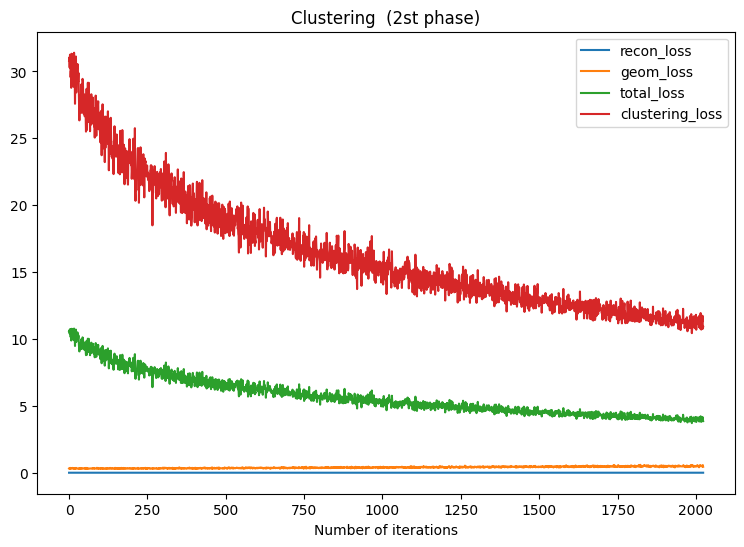

In [16]:
plot_losses(losses2, "Clustering  (2st phase)")

In [17]:
dec_features, pred_clusters = model.transform_and_cluster(base_embeds)
dim_reduction = umap.UMAP(random_state=42, n_components=2)
umap_features = dim_reduction.fit_transform(dec_features)
topics = model.get_topics(base_data['text'].to_list(), base_embeds)

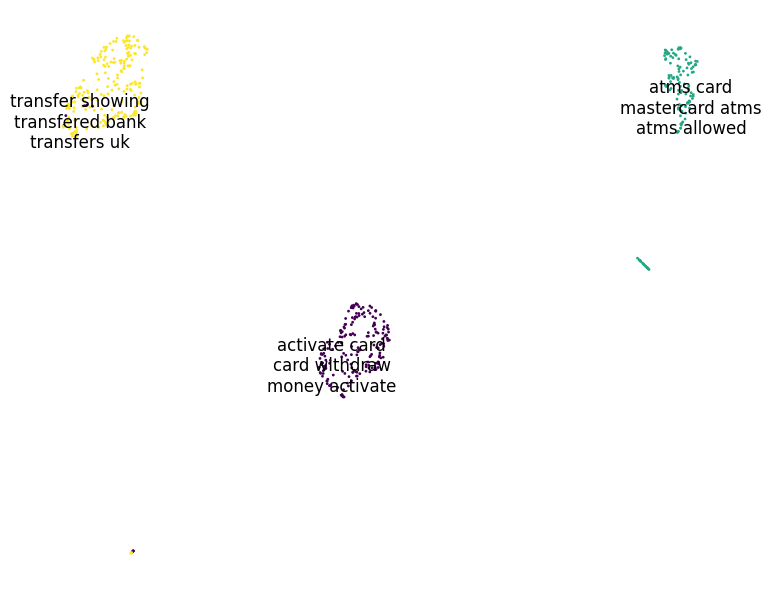

In [18]:
#umap_embeds = model.transform(base_embeds.to(device), batch_size=128)
new_centers = dim_reduction.transform(model.get_centers())
_, pred_clusters = model.transform_and_cluster(base_embeds.to(device))
plt.figure(figsize=(9, 9))
plt.scatter(*umap_features.T, c=base_clusters, s=1.0)
#plt.scatter(*new_umap_embeds.T, c=base_clusters, s=1.0)
for i, (x, y) in enumerate(new_centers):
    plt.text(x, y, "\n".join(topics[i]), 
             horizontalalignment='center', 
             verticalalignment='center', 
             fontsize=12)# backgroundcolor='white')
plt.gca().set_aspect("equal")
plt.axis("off")
#plt.title("Parametric UMAP for Banking77")
#plt.legend()
plt.show()